Using CPU. Note: This module is much faster with a GPU.


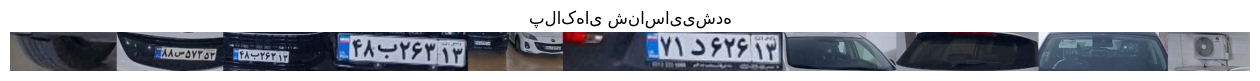

متن‌های شناسایی‌شده:
پلاک 1: 
پلاک 2: ٥٣ ٥٧٣س٥٥
پلاک 3: ٢٦٢ب٤٨ ٣
پلاک 4: ١٣ ٢٦٣ب٠٦٤٨
پلاک 5: ١٣ ٢٦٣ب؛٤ ٥٣ ٥٧٣س٦٨
پلاک 6: ١٣ ٥٦٢٤
پلاک 7: 
پلاک 8: 
پلاک 9: 
پلاک 10: GREL


In [56]:
# بهبود یافته برای شناسایی چندین پلاک ایرانی از تصویر اصلی
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import easyocr

# بارگذاری تصویر اصلی
image_path = 'C:/Users/koosha/Desktop/15.jpg'
car_img = cv.imread(image_path)
car_img_gray = cv.cvtColor(car_img, cv.COLOR_BGR2GRAY)

# افزایش کنتراست و حذف نویز
clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced = clahe.apply(car_img_gray)
blurred = cv.bilateralFilter(enhanced, 11, 75, 75)

# آستانه‌گذاری تطبیقی
thresh = cv.adaptiveThreshold(blurred, 255, cv.ADAPTIVE_THRESH_MEAN_C,
                               cv.THRESH_BINARY_INV, 25, 10)

# یافتن کانتورها
contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[:10]

# فیلتر کانتورها با توجه به نسبت ابعاد و مساحت
plates = []
for cnt in contours:
    x, y, w, h = cv.boundingRect(cnt)
    aspect_ratio = w / float(h)
    area = cv.contourArea(cnt)
    if 2.0 < aspect_ratio < 6.5 and 1500 < area < 18000 and w > 90 and h > 20:
        plates.append((x, y, w, h))

# حذف موارد تکراری نزدیک
final_plates = []
for (x, y, w, h) in plates:
    if all(abs(x - fx) > 30 or abs(y - fy) > 30 for (fx, fy, fw, fh) in final_plates):
        final_plates.append((x, y, w, h))

# آماده‌سازی OCR
reader = easyocr.Reader(['fa', 'en'], gpu=False)
plate_texts = []
plate_rois = []

for (x, y, w, h) in final_plates:
    roi = car_img[y:y+h, x:x+w]
    gray_roi = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
    gray_roi = cv.resize(gray_roi, None, fx=2.5, fy=2.5, interpolation=cv.INTER_LINEAR)
    _, roi_thresh = cv.threshold(gray_roi, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    result = reader.readtext(roi_thresh, detail=1, paragraph=False)
    text = " ".join([res[1] for res in result])
    plate_texts.append(text)
    plate_rois.append(roi)

# نمایش تصویر ترکیبی همه پلاک‌ها
if plate_rois:
    max_height = max([roi.shape[0] for roi in plate_rois])
    resized_rois = [cv.resize(roi, (int(roi.shape[1] * max_height / roi.shape[0]), max_height)) for roi in plate_rois]
    combined = cv.hconcat(resized_rois)
    plt.figure(figsize=(16, 5))
    plt.imshow(cv.cvtColor(combined, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("پلاک‌های شناسایی‌شده")
    plt.show()

# چاپ نتایج
print("متن‌های شناسایی‌شده:")
for i, text in enumerate(plate_texts, 1):
    print(f"پلاک {i}: {text}")
